# Requirements



Your objective will be to calibrate a Hull-White model to ATM caplet market implied volatilities. You will be expected to go through the following steps: 
1. Download ATM cap data, 
2. Program in Python a theoretical closed-form pricing function for the Hull-White model, 
3. Program a Monte-Carlo simulation-based function and 
4. Verify that it produces the same price of all caps as the closed-form solution, and 
5. Calibrate the Hull-White model to the data by minimizing the sum of squared pricing errors over model parameters. 

Your final project deliverables should include clean, bug-free, and well-commented source code accompanied by "Executive Summary" of results with tables, graphs comparing model vs. market implied vols, as well as intelligent comments on model limitations.

Performing well on the group project requires you to write an "Executive Summary" that discusses your modeling techniques and results. Ideally, you should be turning in a professional, well written report that details the motivation for the project, how you implemented the project, and how your results match up to the observed market quantities. While there are no strict requirements for what your executive report should contain, it is suggested that at a minimum the report should contain a well-thought discussion of how you implemented the project, the model limitations, and how well your model fits the data. The remaining choice of content is completely up to you and your group to decide. Please note that this open structure of what you submit for the project enables you to exercise a high degree of flexibility in implementing your results. Thus, creativity is an integral part of the group. Making modeling assumptions is completely valid, and all you need to do is clearly state any assumptions you make and why they are justifiable.

Please keep the executive report to 15 pages or less and only include discussions and graphs. Points will be deducted for including code in the executive report.

# Data Extraction from Blooomberg

Data Source: 

- Bloomberg `SWPM` function
- Type `SWPM -CAP USD` in your bloomberg terminal
- Go to the cashflow tab. This is a table specifying the cash flow property of cap over its tenor

Data for Multiple Caps:

- Bloomberg `VCUB` function
- Select Cap Vol from view
- Select show strikes
- You have a matrix of caps with different tenor and moneyness.

# Data Preprocessing

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import norm
from math import exp, sqrt, log
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
data_path = "../data/"
cap = pd.read_csv(data_path + "cap.csv")

In [3]:
cap

,CapStrike,CapVols,Days,Discount,Expiry,HedgeRatio,IntrinsicPV,Notional,PV,PayDate,Payment,ResetRate,T_i,T_iM1,TimePV,tau_i
0,2.71212,9.82,92,0.987013,07/16/2019,0.17,0.00,10000000,223.73,10/18/2019,226.67,2.57190,0.513889,0.252778,223.73,0.261111
1,2.71212,9.52,95,0.980422,10/16/2019,0.20,0.00,10000000,431.15,01/21/2020,439.76,2.54782,0.777778,0.508333,431.15,0.269444
2,2.71212,9.22,90,0.974283,01/17/2020,0.20,0.00,10000000,491.17,04/20/2020,504.14,2.51966,1.027778,0.766667,491.17,0.261111
3,2.71212,16.23,91,0.968321,04/16/2020,0.28,0.00,10000000,1547.25,07/20/2020,1597.87,2.43567,1.280556,1.016667,1547.25,0.263889
4,2.71212,16.72,91,0.962563,07/16/2020,0.26,0.00,10000000,1557.72,10/19/2020,1618.30,2.36663,1.533333,1.269444,1557.72,0.263889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2.71212,24.74,90,0.448040,01/17/2048,0.34,241.19,10000000,15154.69,04/20/2048,33824.44,2.73365,29.436111,29.175000,14913.50,0.261111
115,2.71212,24.78,91,0.444970,04/16/2048,0.33,195.30,10000000,15259.08,07/20/2048,34292.41,2.72948,29.688889,29.425000,15063.78,0.263889
116,2.71212,24.82,91,0.441925,07/16/2048,0.33,147.29,10000000,15195.79,10/19/2048,34385.43,2.72530,29.941667,29.677778,15048.50,0.263889
117,2.71212,24.86,92,0.438873,10/15/2048,0.32,99.67,10000000,15297.01,01/19/2049,34855.17,2.72100,30.197222,29.930556,15197.34,0.266667


Price Data

- `CapStrike`: Caplet Strike Price $K$
- `CapVols`(%): implied volatility of the cap, $\sigma$ in Black pricing model
- `IntrinsicPV`: $K - K_{ATM}$
- `Discount`: Zero-coupon Bond $P(t, S)$
- `HedgeRatio`: ratio of hedging value of cap to overall value students should not need to use it
- `IntrinsicPV`: time $t$ (current) value of payment if current Libor rate = rate at $T$ (no need to use it)
- `Notional`: Notional Price $N$, a factor to scale payment of cap by

Time Data

- `PayDate`: Date of Payoff $S$
  - `T_i`: Conversion of the Amount of Time between PayDate($S_i$) and Today($t=0$) (according to the Time Convention)
- `Expiry`: Date of Expiry $T$
  - `T_iM1`: Conversion of the Amount of Time between Expiry Date($T_i$) and Today($t=0$) (according to the Time Convention) $T_i - t$
  - actually it's last term's PayDate, so $S_{i-1} = T_i$
- `Days`: Number of Days between expiry date $T$ and pay date $S$
- `tau_i`: $\tau_i = S_i - T_i$
- `T_i` - `T_iM1` = `tau_i`

Today($t=0$): 20190416

In [4]:
zero_curve = cap["Discount"]
market_implied_vol_data = cap["CapVols"]

number_of_caplets = len(cap)
vol_market = market_implied_vol_data / 100

# Maturities of ZCB that can be observed in the market
tm = np.array(cap["T_i"])

# Discount rates of ZCB corresponding to above maturities
ds = zero_curve

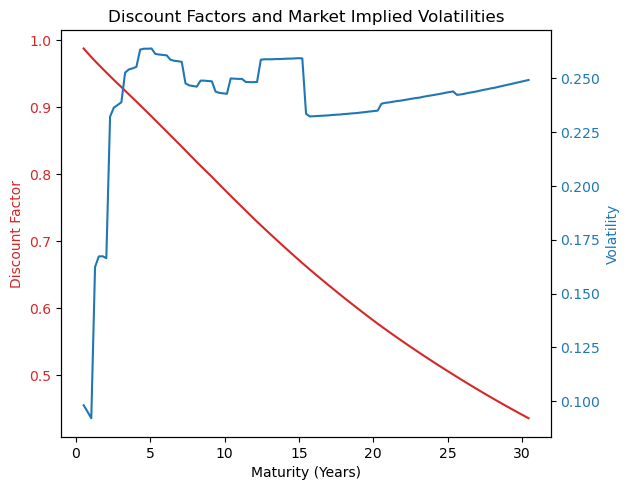

In [5]:
# Creating the plots
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Maturity (Years)")
ax1.set_ylabel("Discount Factor", color=color)
ax1.plot(tm, ds, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
# we already handled the x-label with ax1
ax2.set_ylabel("Volatility", color=color)
ax2.plot(tm, vol_market, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Discount Factors and Market Implied Volatilities")
plt.show()

In [6]:
# Initialize the cap data list
cap_data = []

tm = np.append(0, tm)
ds = np.append(1, ds)

In [7]:
len(tm), len(ds)

(120, 120)

# Functions

## Function 1.X

### Function 1.1 Black Cap Pricing

**Definition 1.2.1. Zero-coupon bond**. 

A T-maturity zero-coupon bond (pure discount bond) is a contract that guarantees its holder the payment of one unit of currency at time $T$, with no intermediate payments. The contract value at time $t<T$ is denoted by $P(t, T)$. Clearly, $P(T, T)=1$ for all $T$

**Definition 1.4.1. Simply-compounded forward interest rate.**

The simply-compounded forward interest rate prevailing at time $t$ for the expiry $T>t$ and maturity $S>T$ is denoted by $F(t  T, S)$ and is defined by
$$
F(t;T, S):=\frac{1}{\tau(T, S)}\left(\frac{P(t, T)}{P(t, S)}-1\right)
$$

It is market practice to price a cap with the following sum of Black's formulas (at time zero)
$$
\mathbf{C a p}^{\text {Black }}\left(0, \mathcal{T}, \tau, N, K, \sigma_{\alpha, \beta}\right)=N \sum_{i=\alpha+1}^\beta P\left(0, T_i\right) \tau_i \operatorname{Bl}\left(K, F\left(0, T_{i-1}, T_i\right), v_i, 1\right)
$$

where, denoting by $\Phi$ the standard Gaussian cumulative distribution function,
$$
\operatorname{Bl}(K, F, v, \omega), 
=F \omega \Phi\left(\omega d_1(K, F, v)\right)-K \omega \Phi\left(\omega d_2(K, F, v)\right)
$$

$$
\begin{aligned}
d_1(K, F, v) & =\frac{\ln (F / K)+v^2 / 2}{v} \\
d_2(K, F, v) & =\frac{\ln (F / K)-v^2 / 2}{v} \\
v_i & =\sigma_{\alpha, \beta} \sqrt{T_{i-1}}
\end{aligned}
$$

In [8]:
def Black_Cap_Pricing(sigma_input=None, input_cap=None, omega=1):
    """Convert Bloomberg Market Implied Vol into Dollar Price - Formula 1.26

    Args:
        cap (dataframe): cap data (default: cap

    Returns:
        float: Black Cap Price
    """
    result_cap = 0
    N = cap["Notional"][0]
    for i in range(1, len(input_cap)):
        # zero-coupon bond price at time t
        # T is the expiry time, T_i = S_i-1
        P_t_T = input_cap["Discount"][i - 1]
        P_t_S = input_cap["Discount"][i]  # S is the maturity time, S_i

        tau_i = input_cap["tau_i"][i]
        # simply-compounded forward rate
        F_t_T_S = (P_t_T / P_t_S - 1) / tau_i
        # strike price
        K = input_cap["CapStrike"][i] / 100
        # volatility
        if sigma_input is None:
            sigma = input_cap["CapVols"][i] / 100
        else:
            sigma = sigma_input
        v = sigma * sqrt(input_cap["T_iM1"][i])
        temp = max(F_t_T_S / K, sys.float_info.min)
        d1 = log(temp)
        d1 += 0.5 * v**2
        d1 /= v
        d2 = d1 - v
        Bl = F_t_T_S * omega * norm.cdf(omega * d1) - K * omega * norm.cdf(omega * d2)
        result_cap += Bl * tau_i * P_t_S

    return result_cap * N


Black_Cap_Pricing(input_cap=cap)

1728326.7099997392

### Function 1.2 Caplets price

Caplet

$$
\mathbf{C p l}\left(t, t_{i-1}, t_i, \tau_i, N, X\right)=N_i^{\prime} \mathbf{Z B P}\left(t, t_{i-1}, t_i, X_i^{\prime}\right)
$$
where
$$
\begin{aligned}
X_i^{\prime}, =\frac{1}{1+X \tau_i} \\
N_i^{\prime}, =N\left(1+X \tau_i\right)
\end{aligned}
$$

In [9]:
def HW_Caplets(a, sigma, r_t, fM_0_t, N, tau, t, T, S, P_t_T, P_t_S, X):
    """
    HW model, Caplets price, based on ZB put Pricing - Formula 2.27

    Args:
        a (float): mean reversion rate
        sigma (float): volatility
        r_t (float): short rate
        fM_0_t (float): forward rate
        N (float): Notional
        tau (float): time to payment
        t (float): current time
        T (float): expiry time
        S (float): maturity time
        P_t_T (float): zero-coupon bond price at time t
        P_t_S (float): zero-coupon bond price at time t
        X (float): strike price
        cap (pd.DataFrame): cap data

    Returns:
        float: Caplets price
    """
    X_prime = 1 / (1 + X * tau)
    N_prime = N * (1 + X * tau)
    return N_prime * HW_ZBPut_CF(a, sigma, r_t, fM_0_t, t, T, S, P_t_T, P_t_S, X_prime)

### Function 1.3 Converted the optimized HW Cap prices into Black Implied Vols

Converted the optimized HW Cap prices into Black Implied Vols

In [10]:
def Price_to_Vol(price, cap=cap, tol=1e-6):
    """
    Converted the optimized HW Cap prices into Black Implied Vols

    Args:
        price (float): Option Price

    Returns:
        float: Implied Volatility
    """
    # initial guess
    sigma = 0.017

    def Black_Cap_Pricing_error(sigma, cap):
        pricing = Black_Cap_Pricing(sigma_input=sigma, input_cap=cap)
        result = (pricing - price) / pricing
        return result**2

    # Black_Cap_Pricing(sigma_input=sigma, input_cap=cap)
    sigma = minimize(
        fun=Black_Cap_Pricing_error, method="Nelder-Mead", x0=sigma, args=(cap), tol=tol
    ).x
    # print(Black_Cap_Pricing_error(sigma, cap))
    return sigma

## Function 2.X

### Function 2.1 HW_Cap


Through formulas $(3.40)$ and (3.41), we can also price caps and floors since they can be viewed as portfolios of zero-bond options. To this end, we denote by $D=\left\{d_1, d_2, \ldots, d_n\right\}$ the set of the cap/floor payment dates and by $\mathcal{T}=$ $\left\{t_0, t_1, \ldots, t_n\right\}$ the set of the corresponding times, meaning that $t_i$ is the difference in years between $d_i$ and the settlement date $t$, and where $t_0$ is the first reset time. Moreover, we denote by $\tau_i$ the year fraction from $d_{i-1}$ to $d_i$, $i=1, \ldots, n$. Applying formula (2.26), we then obtain that the price at time $t<t_0$ of the cap with cap rate (strike) $X$, nominal value $N$ and set of times $\mathcal{T}$ is given by
$$
\mathbf{C a p}(t, \mathcal{T}, N, X)=N \sum_{i=1}^n\left(1+X \tau_i\right) \mathbf{Z B P}\left(t, t_{i-1}, t_i, \frac{1}{1+X \tau_i}\right)
$$
or, more explicitly,

$$
\mathbf{C a p}(t, \mathcal{T}, N, X)=N \sum_{i=1}^n\left[P\left(t, t_{i-1}\right) \Phi\left(-h_i+\sigma_p^i\right)-\left(1+X \tau_i\right) P\left(t, t_i\right) \Phi\left(-h_i\right)\right]
$$
where
3.3 The Hull-White Extended Vasicek Model
77
$$
\begin{aligned}
\sigma_p^i & =\sigma \sqrt{\frac{1-e^{-2 a\left(t_{i-1}-t\right)}}{2 a}} B\left(t_{i-1}, t_i\right), \\
h_i & =\frac{1}{\sigma_p^i} \ln \frac{P\left(t, t_i\right)\left(1+X \tau_i\right)}{P\left(t, t_{i-1}\right)}+\frac{\sigma_p^i}{2} .
\end{aligned}
$$

In [11]:
def HW_Cap(a, sigma, r_t, fM_0_t, t=0, cap=cap):
    """
    HW model, Cap price, based on Caplets price - Formula 3.42

    Args:
        a (float): mean reversion rate
        sigma (float): volatility
        r_t (float): short rate
        f_0_t (float): forward rate
        t (float): current time
        cap (pd.DataFrame): cap data

    Returns:
        float: Cap price
    """
    result = 0
    for i in range(1, len(cap)):
        result += HW_Caplets(
            a,
            sigma,
            r_t,
            fM_0_t,
            N=cap["Notional"][0],
            tau=cap["tau_i"][i],
            t=t,
            T=cap["T_iM1"][i],
            S=cap["T_i"][i],
            P_t_T=cap["Discount"][i - 1],
            P_t_S=cap["Discount"][i],
            X=cap["CapStrike"][i],
        )
    return result

### Function 2.2

Bond and Option Pricing
$$
P(t, T)=A(t, T) e^{-B(t, T) r(t)},
$$
where
$$
A(t, T)=\frac{P^M(0, T)}{P^M(0, t)} \exp \left\{B(t, T) f^M(0, t)-\frac{\sigma^2}{4 a}\left(1-e^{-2 a t}\right) B(t, T)^2\right\} .
$$
$$
B(t, T)=\frac{1}{a}\left[1-e^{-a(T-t)}\right]
$$


In [12]:
def B(a, t, T):
    """
    Calculates the B(a, t, T) function for the Hull-White model.

    Args:
        a (float): mean reversion rate
        t (float): current time
        T (float): expiry time

    Returns:
        float: B(a, t, T) function
    """
    return (1 - np.exp(-a * (T - t))) / a


def HW_ZBPrice_CF(
    a, sigma, r_t, T, t=0, fM_0_t=None, PM_0_T=None, times=None, discounts=None
):
    """
    HW model, Analytical Solution for Zero Coupon Bond - Formula 3.39

    Args:
        a (float): mean reversion rate
        sigma (float): volatility
        r_t (float): short rate
        f_0_t (float): forward rate
        t (float): current time
        T (float): expiry time
        P_M (float): zero-coupon bond price at time M
        time (float): time to payment
        discount (float): discount rate

    Returns:
        float: Zero Coupon Bond price
    """
    B_t_T = B(a, t, T)

    if fM_0_t is None:
        fM_0_t = fM(t, times, discounts)
    if PM_0_T is None:
        PM_0_T = PM(T, times, discounts)
        PM_0_t = PM(t, times, discounts)
    else:
        PM_0_t = 1

    A_t_T = (
        PM_0_T
        / PM_0_t
        * np.exp(
            B_t_T * fM_0_t - (sigma**2 / (4 * a)) * (1 - exp(-2 * a * t)) * B_t_T**2
        )
    )

    result = A_t_T * np.exp(-B_t_T * r_t)
    return result

### Function 2.3

Definition 1.2.3. Continuously-compounded spot interest rate. The continuously-compounded spot interest rate prevailing at time $t$ for the maturity $T$ is denoted by $R(t, T)$ and is the constant rate at which an investment of $P(t, T)$ units of currency at time $t$ accrues continuously to yield a unit amount of currency at maturity $T$. In formulas:
$$
R(t, T):=-\frac{\ln P(t, T)}{\tau(t, T)}
$$

The continuously-compounded interest rate is therefore a constant rate that is consistent with the zero-coupon-bond prices in that
$$
e^{R(t, T) \tau(t, T)} P(t, T)=1,
$$
from which we can express the bond price in terms of the continuouslycompounded rate $R$ :
$$
P(t, T)=e^{-R(t, T) \tau(t, T)} .
$$

A classic problem with the above models is their endogenous nature. If we have the initial zero-coupon bond curve $T \mapsto P^M(0, T)$ from the market, and we wish our model to incorporate this curve, we need forcing the model parameters to produce a model curve as close as possible to the market curve. For example, again in the Vasicek case, we need to run an optimization to find the values of $k, \theta$ and $\sigma$ such that the model initial curve $T \mapsto P(0, T  k, \theta, \sigma, r(0))$ is as close as possible to the market curve $T \mapsto P^M(0, T)$. Although the values $P^M(0, T)$ are actually observed only at a finite number of maturities $P^M\left(0, T_i\right)$, three parameters are not enough to reproduce satisfactorily a given term structure. Moreover, some shapes of the zero-coupon curve $T \mapsto L^M(0, T)$ (like an inverted shape) can never be obtained with the Vasicek model, no matter the values of the parameters in the dynamics that are chosen.

In [13]:
# The PM function needs to be defined or replaced with an equivalent that calculates present value multipliers
def PM(period, tm=tm, ds=ds):
    # This function should interpolate the discount factors based on the provided period
    # Using np.interp for linear interpolation as a simple example
    return np.interp(period, tm, ds)

Throughout the chapter, we assume that the term structure of discount factors that is currently observed in the market is given by the sufficientlysmooth function $t \mapsto P^M(0, t)$. We then denote by $f^M(0, t)$ the market instantaneous forward rates at time 0 for a maturity $t$ as associated with the bond prices $\left\{P^M(0, t): t \geq 0\right\}$, i.e.,
$$
f^M(0, t)=-\frac{\partial \ln P^M(0, t)}{\partial t} .
$$

In [14]:
def fM(t, times=tm, discounts=ds, delta=0.001):
    """interpolate a continuous instantaneous forward rate based on the ZCB discount curve

    Args:
        t (float): input time
        times (float): market observable ZCB maturities (S)
        discount (float): market observable ZCB discounts (P_t_S)
        delta (float): time interval

    Returns:
        float: the interpolated forward rate
    """
    PMleft = PM(t - delta, tm=times, ds=discounts)
    PMright = PM(t + delta, tm=times, ds=discounts)
    logPMleft = log(PMleft)
    logPMright = log(PMright)
    if t == 0:
        result = -(logPMright - logPMleft) / (delta)
    else:
        result = -(logPMright - logPMleft) / (2 * delta)
    return result


# print(fM(0))
# print(fM(1))


Equation (3.33) can be easily integrated so as to yield
$$
\begin{aligned}
r(t) & =r(s) e^{-a(t-s)}+\int_s^t e^{-a(t-u)} \vartheta(u) d u+\sigma \int_s^t e^{-a(t-u)} d W(u) \\
& =r(s) e^{-a(t-s)}+\alpha(t)-\alpha(s) e^{-a(t-s)}+\sigma \int_s^t e^{-a(t-u)} d W(u),
\end{aligned}
$$
where
$$
\alpha(t)=f^M(0, t)+\frac{\sigma^2}{2 a^2}\left(1-e^{-a t}\right)^2 .
$$

In [15]:
def alpha(t, a, sigma, times, discounts):
    """alpha function for the r(t) process

    Args:
        t (float): input time
        a (float): mean reversion rate
        sigma (float): volatility
        times (float): market observable ZCB maturities (S)
        discount (float): market observable ZCB discounts (P_t_S)

    Returns:
        float: alpha function
    """
    result = fM(t, times, discounts) + sigma**2 / (2 * a**2) * (1 - exp(-a * t)) ** 2
    return result


def r_t(a, sigma, r_0, t, times, discounts):
    """r(t) process, set s = 0

    Args:
        r_s (float):
        a (float):
        sigma (float): volatility
        t (float):
        times (np.array):
        discounts (np.array):

    Returns:
        float: _description_
    """
    dW = np.random.normal()
    vol = sqrt(sigma**2 / (2 * a) * (1 - exp(-2 * a * t)))
    alpha_t = alpha(t, a, sigma, times, discounts)
    alpha_0 = alpha(0, a, sigma, times, discounts)
    result = r_0 * exp(-a * t) + alpha_t - alpha_0 * exp(-a * t) + vol * dW
    return result

In particular, the zero-coupon-bond price at time $t$ for the maturity $T$ is characterized by a unit amount of currency available at time $T$, so that $H_T=1$ and we obtain
$$
P(t, T)=E_t\left\{e^{-\int_t^T r(s) d s}\right\}
$$

In [16]:
def HW_ZBPrice_SM(a, sigma, r_s, T, L, M, times, discounts):
    """HW model, Monte Carlo Simulation for Zero Coupon Bond - Formula 3.2

    Args:
        a (float): mean reversion rate
        sigma (float): volatility
        r_s (float): short rate
        T (float): expiry time
        L (int): number of simulations
        M (int): number of time steps
        times (np.array): market observable ZCB maturities (S)
        discounts (np.array): market observable ZCB discounts (P_t_S)

    Returns:
        float: Zero Coupon Bond price
    """
    delta_t = T / M
    result_sum = 0
    for _ in range(0, L):
        s = 0
        for j in range(0, M):
            r = r_t(r_s, a, sigma, j * delta_t, times, discounts)
            s = s + r * delta_t
        result_sum += np.exp(-s)
    result = result_sum / L
    return result

### Function 2.4

As a consequence, the European call-option price is
$$
\mathbf{Z B C}(t, T, S, X)=P(t, S) \Phi(h)-X P(t, T) \Phi\left(h-\sigma_p\right),
$$
where
$$
\begin{aligned}
\sigma_p & =\sigma \sqrt{\frac{1-e^{-2 a(T-t)}}{2 a}} B(T, S), \\
h & =\frac{1}{\sigma_p} \ln \frac{P(t, S)}{P(t, T) X}+\frac{\sigma_p}{2} .
\end{aligned}
$$

Analogously, the price $\mathbf{Z B P}(t, T, S, X)$ at time $t$ of a European put option with strike $X$, maturity $T$ and written on a pure discount bond maturing at time $S$ is given by
$$
\mathbf{Z B P}(t, T, S, X)=X P(t, T) \Phi\left(-h+\sigma_p\right)-P(t, S) \Phi(-h) .
$$

In [17]:
def HW_ZBPut_CF(a, sigma, r_t, fM_0_t, t, T, S, P_t_T, P_t_S, X):
    """Calculate the price of a European put option on a zero-coupon bond.

    Args:
        a (float): The speed of mean reversion.
        sigma (float): The volatility of the short rate.
        r_t (float): The short rate at time t.
        fM_0_t (float): The forward rate at time t.
        P_t_T (float): The price of a zero-coupon bond with maturity T at time t.
        P_t_S (float): The price of a zero-coupon bond with maturity S at time t.
        X (float): The strike price of the option.
        t (float): The current time.
        T (float): The maturity of the option.
        S (float): The maturity of the zero-coupon bond.

    Returns:
        float: The price of the option.
    """
    B_T_S = B(a, T, S)
    sigma_p = sigma * sqrt((1 - np.exp(-2 * a * (T - t))) / (2 * a)) * B_T_S
    P_t_S = HW_ZBPrice_CF(a, sigma, r_t, S, t=t, fM_0_t=fM_0_t, PM_0_T=P_t_S)
    P_t_T = HW_ZBPrice_CF(a, sigma, r_t, T, t=t, fM_0_t=fM_0_t, PM_0_T=P_t_T)
    # h = (1/sigma_p) * log(P_t_S / P_t_T * X) + sigma_p / 2
    temp = max(P_t_S / (P_t_T * X), sys.float_info.min)
    h = (1 / sigma_p) * log(temp)
    h = h + sigma_p / 2
    # result = max(X * P_t_T * norm.cdf(-h + sigma_p) - P_t_S * norm.cdf(-h), 0)
    result = X * P_t_T * norm.cdf(-h + sigma_p) - P_t_S * norm.cdf(-h)
    return result

### Function 2.5

The particular case of a European call option with maturity $T$, strike $X$ and written on a unit-principal zero-coupon bond with maturity $S>T$ leads to the pricing formula
$$
\mathbf{Z B C}(t, T, S, X)=E\left(e^{-\int_t^T r_s d s}(P(T, S)-X)^{+} \mid \mathcal{F}_t\right)
$$

In [18]:
def HW_ZBPut_SM_Q(a, sigma, r_0, t, T, S, X, L, M, time, discounts):
    # determine the time step
    delta_t = T / L

    # initialize the payoff (cumulative payoff)
    payoff = 0
    # simulate the short rate M times
    for _ in range(M):
        # initialize the integral of r
        Integral_r = 0
        # simulate the short rate
        for j in range(L):
            # simulate the short rate at time t(t = 0 as default) + j * delta_t
            r = r_t(a, sigma, r_0, t + j * delta_t, time, discounts)
            Integral_r += r * delta_t
            # calculate the payoff by Formula 2.23
            payoff += np.exp(-Integral_r) * max(
                0,
                X - HW_ZBPrice_CF(a, sigma, r, S, t=T, times=time, discounts=discounts),
            )

    # calculate the result
    return payoff / M


# HW_ZBPut_SM_Q(a=0.1, sigma=0.02, r_0=0.02, t=0, T=1, S=2,
#               X=2, L=10000, M=100, time=tm, discounts=ds)

### Function 2.6

Similarly, the price $\mathbf{Z B C}(t, T, S, X)$ at time $t$ of a European call option with strike $X$, maturity $T$ and written on a pure discount bond maturing at time $S$ is given by the expectation (2.23) or, equivalently, by (2.25). To compute the latter expectation, we need to know the distribution of the process $r$ under the $T$-forward measure $Q^T$. Since the process $x$ corresponds to the Vasicek's $r$ with $\theta=0$, we can use formula (3.9) to get
$$
d x(t)=\left[-B(t, T) \sigma^2-a x(t)\right] d t+\sigma d W^T(t),
$$
where the $Q^T$-Brownian motion $W^T$ is defined by $d W^T(t)=d W(t)+$ $\sigma B(t, T) d t$, so that, for $s \leq t \leq T$,
$$
x(t)=x(s) e^{-a(t-s)}-M^T(s, t)+\sigma \int_s^t e^{-a(t-u)} d W^T(u)
$$
with
${ }^8$ The following formulas can be derived through the same methodology we illustrate in detail in Chapter 4 for the G2++ model
76
3. One-factor short-rate models
$$
M^T(s, t)=\frac{\sigma^2}{a^2}\left[1-e^{-a(t-s)}\right]-\frac{\sigma^2}{2 a^2}\left[e^{-a(T-t)}-e^{-a(T+t-2 s)}\right] .
$$
It is then easy to realize that the distribution of the short rate $r(t)$ conditional on $\mathcal{F}_s$ is, under the measure $Q^T$, still Gaussian with mean and variance given respectively by
$$
\begin{aligned}
E^T\left\{r(t) \mid \mathcal{F}_s\right\} & =x(s) e^{-a(t-s)}-M^T(s, t)+\alpha(t), \\
\operatorname{Var}^T\left\{r(t) \mid \mathcal{F}_s\right\} & =\frac{\sigma^2}{2 a}\left[1-e^{-2 a(t-s)}\right] .
\end{aligned}
$$

In [19]:
# def x_t(x0, a, sigma, t):
#     """x(t) process, set s = 0

#     Args:
#         x0 (float): _description_
#         a (float): _description_
#         sigma (float): volatility
#         t (float): target maturity time

#     Returns:
#         float: x(t) value at time t
#     """
#     T = t
#     s = 0
#     dW = norm.inv(np.rand())
#     MT_0_t = sigma ^ 2/(a ^ 2) * (1 - exp(- a * (t - s))) - sigma ^ 2 / \
#         (2 * a ^ 2) * (exp(-a * (T - t))-exp(-a * (T + t - 2 * s)))
#     vol = sqrt(sigma ^ 2 / (2 * a) * (1 - exp(- 2 * a * t)))
#     result = x0 * exp(- a * t) - MT_0_t + vol * dW
#     return result

In the case of the above call option, we then have
$$
\mathbf{Z B C}(t, T, S, X)=P(t, T) E^T\left((P(T, S)-X)^{+} \mid \mathcal{F}_t\right)
$$

In [20]:
def HW_ZBPut_SM_T(a, sigma, r0, t, T, S, X, M, time, discounts):
    """
    Calculate the price of a European put option on a zero-coupon bond using Monte Carlo simulation under T measure.

    Parameters:
    a (float): Mean reversion parameter of the Hull-White model.
    sigma (float): Volatility parameter of the Hull-White model.
    r0 (float): Initial short rate.
    t (float): Time at which the option is priced.
    T (float): Time to maturity of the option.
    S (float): Time at which the bond price is observed.
    X (float): Strike price of the option.
    M (int): Number of Monte Carlo simulations.
    discounts (array): List of discount factors.

    Returns:
    float: The price of the European put option.

    """
    payoff = 0
    # Calculate the zero-coupon bond prices
    P_0_t = HW_ZBPrice_CF(a, sigma, r0, t, t=0, times=time, discounts=discounts)
    P_0_T = HW_ZBPrice_CF(a, sigma, r0, T, t=0, times=time, discounts=discounts)
    P_t_T = P_0_T / P_0_t

    # do the monte carlo process
    for i in range(M):
        r = r_t(a, sigma, r0, T, time, discounts)
        payoff += P_t_T * max(
            0, X - HW_ZBPrice_CF(a, sigma, r, S, t=T, times=time, discounts=discounts)
        )

    # Calculate the result
    result = payoff / M
    return result


# HW_ZBPut_SM_T(a=0.1, sigma=0.02, r0=0.02, t=0, T=1,
#               S=2, X=2, M=10000, time=tm, discounts=ds)

## Funciton 3.X

### Function 3.1

In [21]:
def HW_Cap_Optimizer(input_para, fM_0_t, cap_market_value, cap_data):
    """This function returns value of loss function between actual market cap prices and model cap prices, and is used for optimization

    Args:
        a (float): The speed of mean reversion.
        sigma (float): The volatility of the short rate.
        r0 (float): The short rate at time 0
        fM_0_t (float):  The forward rate at time t
        cap_data (list): All cap data
        cap_market_value (np.array): the market price

    Returns:
        float: loss function value
    """
    n = len(cap_data)
    cap_model_value = np.zeros(n)

    a = input_para[0]
    sigma = input_para[1]
    r_0 = input_para[2]

    # fM_0_t = r_0

    for i in range(n):
        this_cap = cap_data[i]
        cap_model_value[i] = HW_Cap(a, sigma, r_0, fM_0_t, cap=this_cap)

    cap_diff = (cap_market_value - cap_model_value) / cap_market_value
    cap_sqrt_diff = cap_diff * cap_diff

    return 0.5 * sum(cap_sqrt_diff)

### Function 3.2

In [22]:
cap_data = []
# Iterate over each row in the market implied volatility data to construct cap data
for i in range(0, number_of_caplets):
    start = cap["T_iM1"][i]
    end = cap["T_i"][i]
    interval = cap["tau_i"][i] / 2
    n = 1 + int((end - start) / interval)

    capp = np.zeros((n, 7))
    capp[:, 0] = np.arange(start, end, interval)
    # First column is the new T_i
    capp[:, 1] = PM(capp[:, 0])
    # Second column is the discount factor
    capp[:, 2] = np.array([cap["CapStrike"][i] / 100] * n)
    # Third column is the strike price
    capp[:, 3] = np.array([cap["CapVols"][i] / 100] * n)
    # Fourth column is the volatility
    capp[:, 4] = np.array([interval] * n)
    # Fifth column is tau_i
    capp[:, 5] = np.array(capp[:, 0] - interval)
    capp[:, 6] = np.array([cap["Notional"][0]] * n)

    this_df = pd.DataFrame(
        capp,
        columns=[
            "T_i",
            "Discount",
            "CapStrike",
            "CapVols",
            "tau_i",
            "T_iM1",
            "Notional",
        ],
    )

    cap_data.append(this_df)

In [23]:
print(cap_data[3])
print(len(cap_data))

        T_i  Discount  CapStrike  CapVols     tau_i     T_iM1    Notional
0  1.016667  0.974556   0.027121   0.1623  0.131944  0.884722  10000000.0
1  1.148611  0.971433   0.027121   0.1623  0.131944  1.016667  10000000.0
2  1.280556  0.968321   0.027121   0.1623  0.131944  1.148611  10000000.0
119


In [ ]:
cap_market_value = []
for i in range(0, number_of_caplets):
    cap_market_value.append(Black_Cap_Pricing(input_cap=cap_data[i]))

In [116]:
cap_market_value = np.array(cap_market_value)

In [26]:
fM_0_t = fM(0)
fM_0_t

0.025272319342392904

# Optimization

## Run Optimization

In [ ]:
from scipy.optimize import differential_evolution

input_para = [0.01, 0.2, 0.02]
bounds = ((0.005, 5), (0.005, 1), (0, 0.1))

# input_para = minimize(
#     fun=HW_Cap_Optimizer,
#     x0=input_para,
#     method="L-BFGS-B",
#     bounds=bounds,
#     args=(fM_0_t, cap_market_value, cap_data),
#     # tol=1e-10,
#     options={"maxiter": 1000000000}
# ).x

input_para = differential_evolution(
    func=HW_Cap_Optimizer,
    bounds=bounds,
    args=(fM_0_t, cap_market_value, cap_data),
    tol=1e-6,
    popsize=200,
)

input_para = input_para.x if input_para.success else None

In [114]:
percentage_loss = HW_Cap_Optimizer(input_para, fM_0_t, cap_market_value, cap_data)
print("Loss function value: ", percentage_loss)

output_para = input_para if input_para is not None else None
print("a    : ", output_para[0])
print("sigma: ", output_para[1])
print("r_0  : ", output_para[2])

Loss function value:  0.11330554133628806
a    :  0.9999999960535858
sigma:  0.10222093449500828
r_0  :  0.03684409307754137


## Plots

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

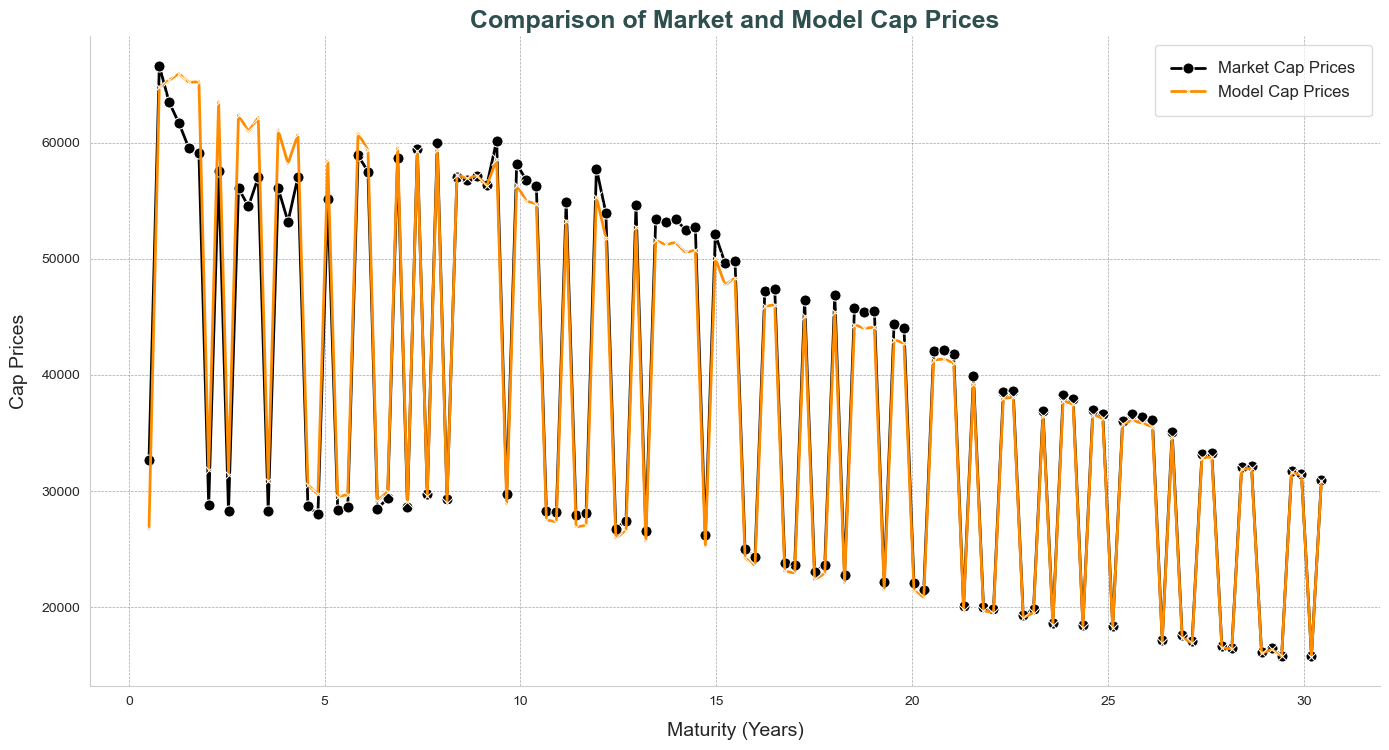

In [117]:
# Set overall style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Enhanced line plot with customization
sns.lineplot(
    x=tm[1:],
    y=cap_market_value,
    marker="o",
    markersize=8,
    linewidth=2,
    color="black",
    label="Market Cap Prices",
)
sns.lineplot(
    x=tm[1:],
    y=[
        HW_Cap(output_para[0], output_para[1], output_para[2], fM_0_t, cap=cap_data[i])
        for i in range(number_of_caplets)
    ],
    marker="x",
    markersize=8,
    linewidth=2,
    color="darkorange",
    label="Model Cap Prices",
)

# Customize title and labels with larger font sizes
plt.title(
    "Comparison of Market and Model Cap Prices",
    fontsize=18,
    fontweight="bold",
    color="darkslategray",
)
plt.xlabel("Maturity (Years)", fontsize=14, labelpad=10)
plt.ylabel("Cap Prices", fontsize=14, labelpad=10)

# Set legend with improved style
plt.legend(
    fontsize=12,
    loc="upper right",
    frameon=True,
    fancybox=True,
    framealpha=0.7,
    borderpad=1,
)

# Customize grid and remove spines for a cleaner look
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
sns.despine(left=False, bottom=False)

# Adjust layout for better padding
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

In [107]:
# from zero curve to interest rate
zero_rates = -np.log(zero_curve) / tm[1:]

In [119]:
vol_optim = []
for i in range(0, number_of_caplets):
    this_cap = cap_data[i]
    cap_model_value_optim = HW_Cap(
        output_para[0], output_para[1], output_para[2], fM_0_t, cap=this_cap
    )
    vol_optim.append(Price_to_Vol(cap_model_value_optim, cap=this_cap))

In [120]:
vol_optim = pd.Series(vol_optim)
precision = abs(sum(vol_optim - vol_market) / number_of_caplets)
precision

array([0.22227227])

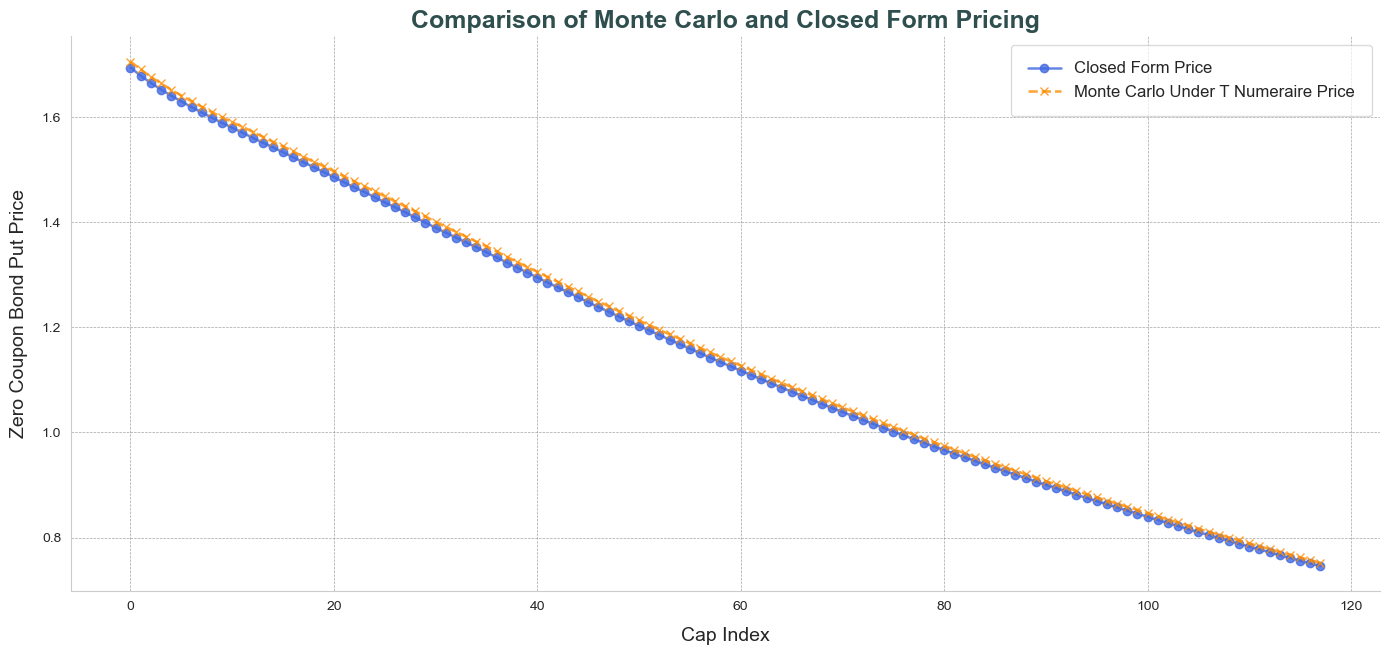

In [123]:
real_put_price = []
simulated_put_price = []

for i in range(118):
    real_put_price.append(
        HW_ZBPut_CF(
            a=input_para[0],
            sigma=input_para[1],
            r_t=input_para[2],
            fM_0_t=fM(0),
            t=0,
            T=cap["T_iM1"][i],
            S=cap["T_i"][i],
            P_t_T=cap["Discount"][i],
            P_t_S=cap["Discount"][i + 1],
            X=2.71212,
        )
    )
    simulated_put_price.append(
        HW_ZBPut_SM_T(
            a=input_para[0],
            sigma=input_para[1],
            r0=input_para[2],
            t=0,
            T=cap["T_iM1"][i],
            S=cap["T_i"][i],
            X=2.71212,
            M=10000,
            time=tm,
            discounts=ds,
        )
    )

# Creating an x-axis label from 0 to 117
x_values = list(range(118))

# Set the overall style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Enhanced plot with distinct line styles and improved color contrast
plt.plot(
    x_values,
    real_put_price,
    label="Closed Form Price",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1.8,
    color="royalblue",
    alpha=0.8,
)
plt.plot(
    x_values,
    simulated_put_price,
    label="Monte Carlo Under T Numeraire Price",
    marker="x",
    markersize=6,
    linestyle="--",
    linewidth=1.8,
    color="darkorange",
    alpha=0.8,
)

# Adding title and labels with larger font sizes and color
plt.title(
    "Comparison of Monte Carlo and Closed Form Pricing",
    fontsize=18,
    fontweight="bold",
    color="darkslategray",
)
plt.xlabel("Cap Index", fontsize=14, labelpad=10)
plt.ylabel("Zero Coupon Bond Put Price", fontsize=14, labelpad=10)

# Customize legend with better placement and styling
plt.legend(
    fontsize=12,
    loc="upper right",
    frameon=True,
    fancybox=True,
    framealpha=0.7,
    borderpad=1,
)

# Customize grid and remove spines for a cleaner look
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
sns.despine(left=False, bottom=False)

# Adjust layout for padding
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()
